# ToDo:
- Provide comments on how to download e.g. dfm_tools maybe? Generally work more on the comments
- Share with Bjorn and push Git and later look into using instructions to run the model externally
- could still add cross-section extractions, for example? Should be able to find from dfm_tool examples

## Import Packages:

In [8]:
import os
import numpy as np
import xarray as xr

import dfm_tools as dfmt
from dfm_tools.xarray_helpers import preprocess_hisnc

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

## Load raw data:

In [3]:
basedir = r"C:\Users\\heye\OneDrive - Stichting Deltares\Documents\Projects\C-SCALE\output\2023-01-23\raw"

In [4]:
f = os.path.join(basedir, fr"tttz_waq_0000_map.nc")
waq_xr = dfmt.open_partitioned_dataset(f.replace('_0000_','_0*_'))  # Open every .map file in this folder

>> xu.open_dataset() with 8 partition(s): 1 2 3 4 5 6 7 8 : 4.17 sec
>> xu.merge_partitions() with 8 partition(s): 1.58 sec
>> dfmt.open_partitioned_dataset() total: 5.77 sec


## Plotting a single time step

C:\Users\heye\Anaconda3\envs\dfm_tools_env\lib\site-packages\cartopy\crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


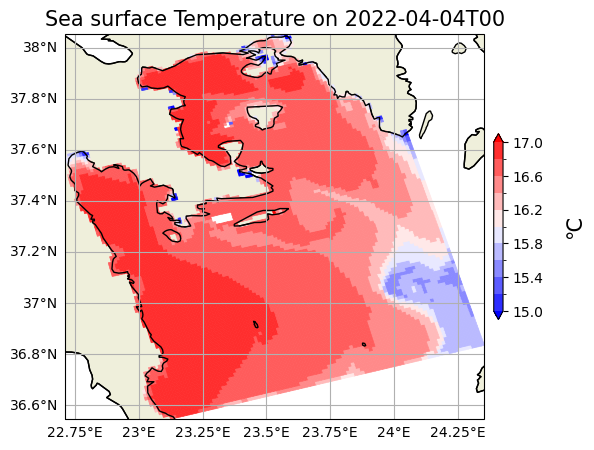

In [175]:
# Select the temperature parameter, at the date and depth we want, and store it in a variable.
date_plot='2022-04-04T00' # Define a date that is available in the product
temp_map = waq_xr['mesh2d_tem1'].sel(time=date_plot).sel(mesh2d_nLayers=-1).squeeze()

# Define the characteristics of the plot
f = plt.figure(figsize=(6, 5))                                             # create a figure and define its size
ax = plt.axes(projection=ccrs.PlateCarree())                               # create an ax and select the projection of the map
ax.coastlines()                                                            # add the coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)                # add the longitude / latitude lines
gl.right_labels = False                                                    # remove latitude labels on the right
gl.top_labels = False                                                      # remove longitude labels on the top
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')                     # add land mask
ax.set_extent([22.5, 24.5, 36.5, 38],crs=ccrs.PlateCarree())               # define the extent of the map [lon_min,lon_max,lat_min,lat_max]

# Plot the sea surface temperature, set the min/max values of the colorbar and the colormap to use
start,stop,step = 15,17,0.2
boundaries = np.array([i for i in np.arange(start, stop +1E-6, step)])
im = temp_map.ugrid.plot(ax=ax, linewidth=0.5, edgecolors='face', cmap='bwr', add_colorbar=False, levels=boundaries)
    
# Add the titles and legend
ax.set_title('Sea surface Temperature on {}'.format(date_plot),fontsize=15, y=1)              # add a title to the figure
cbar = f.colorbar(im,ax=ax,fraction=0.02, pad=0.02, extend='both')                            # add the colorbar
cbar.set_label('\u2103', rotation=90,fontsize=15, labelpad=15)                                # add the title of the colorbar

# Save figure
# plt.savefig('out/temp_map.png')

## Cropping / Zooming on Map

In [133]:
# Define the coordinates of an area of interest

LAT_MIN = 36.8
LAT_MAX = 37
LON_MIN = 23.75
LON_MAX = 24.25

In [156]:
## Select the variable, vertical level (here = surface = -1) and the location, defined above

variable = 'mesh2d_tem1'
temp_GB = waq_xr[variable].sel(mesh2d_nLayers=-1).ugrid.sel(x=slice(LON_MIN,LON_MAX),y=slice(LAT_MIN,LAT_MAX))

Text(0.5, 1.0, 'Cropped sea water temperature')

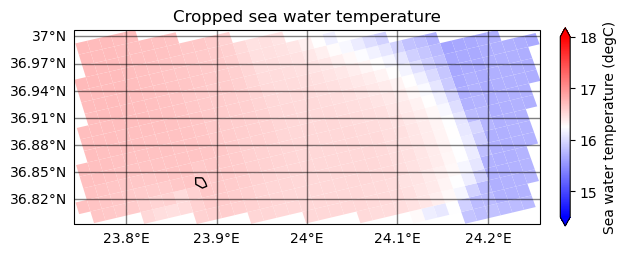

In [181]:
## Plotting

# Grid:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
gls = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

# Plotting the variable defined in the box above and the colorbar:
c = temp_GB[-1,:].ugrid.plot(vmin=14.5, vmax=18, cmap='bwr', add_colorbar=False)
cbar = plt.colorbar(c, label=temp_GB.attrs['standard_name'].capitalize().replace("_", " ")+' ('+temp_GB.attrs['units']+')', 
             extend = 'both', fraction=0.02, pad=0.04)

plt.title('Cropped '+temp_GB.attrs['standard_name'].replace("_", " "))

## Plot SST & Surface Currents

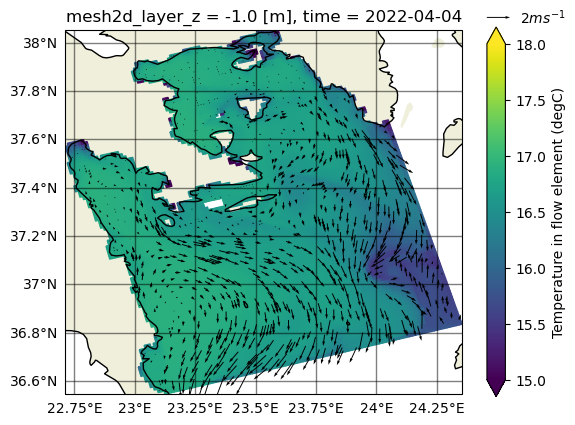

In [195]:
## Plotting the grid
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim(22.5, 24.5)
ax.set_ylim(36.5, 38)
ax.add_feature(cfeature.LAND)
gls = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

## Choosing the variable and plotting the background colour: surface = -1 and last time step = -1
variable = 'mesh2d_tem1'
c = waq_xr[variable][-1,:,-1].ugrid.plot(edgecolors='face', vmin=15, vmax=18, add_colorbar=False)
plt.colorbar(c, label=waq_xr[variable].attrs['long_name']+' ('+waq_xr[variable].attrs['units']+')', extend = 'both')

## Plotting the velocity arrows (every 10th in this case, at the surface and at the last available time step)
Q = plt.quiver(waq_xr[variable][-1,::10,-1].mesh2d_face_x, waq_xr[variable][-1,::10,-1].mesh2d_face_y,
           waq_xr['mesh2d_ucx'][-1,::10,-1], waq_xr['mesh2d_ucy'][-1,::10,-1])
plt.quiverkey(Q, 0.82, 0.9, 2, r'$2ms^{-1}$', labelpos='E', coordinates='figure') # Key for the arrows

## Note: Do not used the first timestep as this has uniform temperatures = initial

## Water Quality variable + Currents

#### Continuous colorbar:

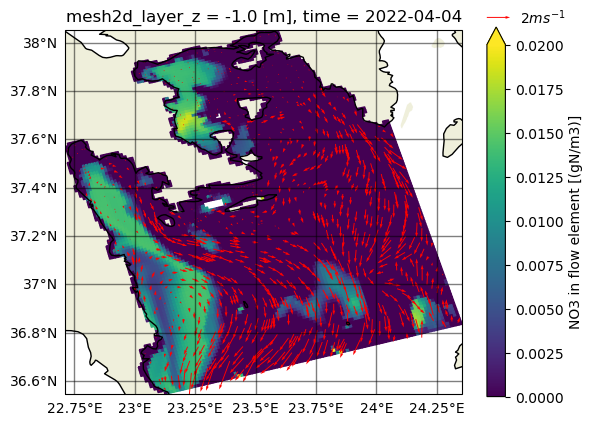

In [193]:
variable = 'mesh2d_NO3'  # Choose the variable of interest for the background colour

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
gls = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

# Plotting background colour:
waq_xr[variable][-1,:,-1].ugrid.plot(edgecolors='face', vmin=0, vmax=0.02)  # vmin/vmax set the colourbar limits

## Plotting the arrows (every 10th in this case, at the surface and at the last available time step)
Q = plt.quiver(waq_xr[variable][-1,::10,-1].mesh2d_face_x, waq_xr[variable][-1,::10,-1].mesh2d_face_y,  # x,y
               waq_xr['mesh2d_ucx'][-1,::10,-1], waq_xr['mesh2d_ucy'][-1,::10,-1],                      # u,v
               color='r', pivot='mid')
qk = plt.quiverkey(Q, 0.82, 0.9, 2, r'$2ms^{-1}$', labelpos='E', coordinates='figure') # Key for the arrows


## Could transform to log

#### Discretized colorbar:

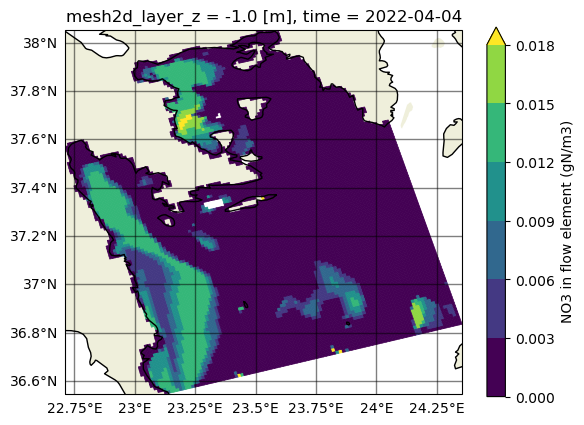

In [122]:
variable = 'mesh2d_NO3'

start,stop,step = 0,0.02,0.003
cmap = "viridis"
bounds = [i for i in np.arange(start, stop +1E-6, step)]
boundaries = np.array(bounds)

## Plotting the grid
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim(22.5, 24.5)
ax.set_ylim(36.5, 38)
ax.add_feature(cfeature.LAND)
gls = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, draw_labels=True)
gls.top_labels=False   # suppress top labels
gls.right_labels=False # suppress right labels

## Plotting the background colour
pc = waq_xr[variable][-1,:,-1].ugrid.plot(ax=ax, linewidth=0.5, edgecolors='face', cmap=cmap, add_colorbar=False, levels=boundaries)
plt.colorbar(pc, ax=ax,label=waq_xr[variable].attrs['long_name']+' '+waq_xr[variable].attrs['units'], extend = 'max')

## Plot a timeseries of SST for a specific location in the domain

### Using .his files:

In [123]:
## Read the .his file
his_file = os.path.join(basedir, fr"tttz_waq_0000_his.nc")
data_xr = xr.open_mfdataset(his_file, preprocess=preprocess_hisnc)

#### Quick plot:

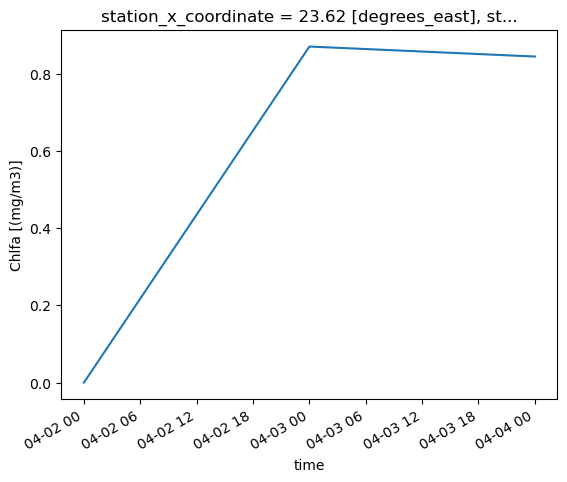

In [124]:
variable = 'water_quality_output_17'  # choose variable from data_xr output
data_xr[variable][:,0,-1].plot()

#### Comparing different stations:

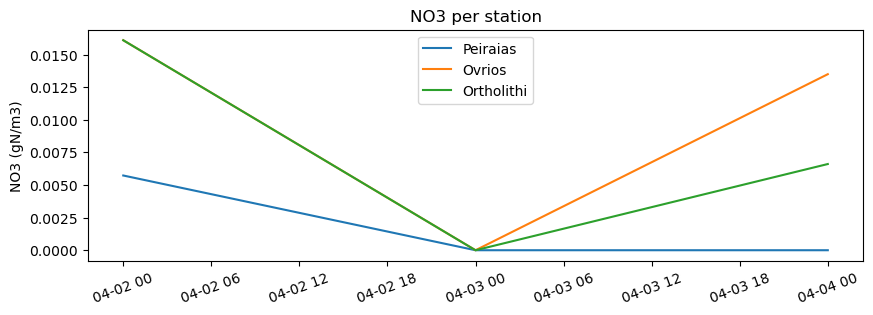

In [117]:
variable = 'NO3'

plt.figure(figsize=(10,3))

plt.plot(data_xr[variable].time, data_xr[variable][:,0,-1], label=data_xr[variable][:,0,-1].stations.values)  
plt.plot(data_xr[variable].time, data_xr[variable][:,1,-1], label=data_xr[variable][:,1,-1].stations.values)  
plt.plot(data_xr[variable].time, data_xr[variable][:,2,-1], label=data_xr[variable][:,2,-1].stations.values) 

xticks = plt.xticks(rotation=20)
plt.ylabel(data_xr[variable].attrs['long_name']+' '+data_xr[variable].attrs['units'])
plt.title(data_xr[variable].attrs['long_name']+' per station')

plt.legend()

#### Comparing different variables:

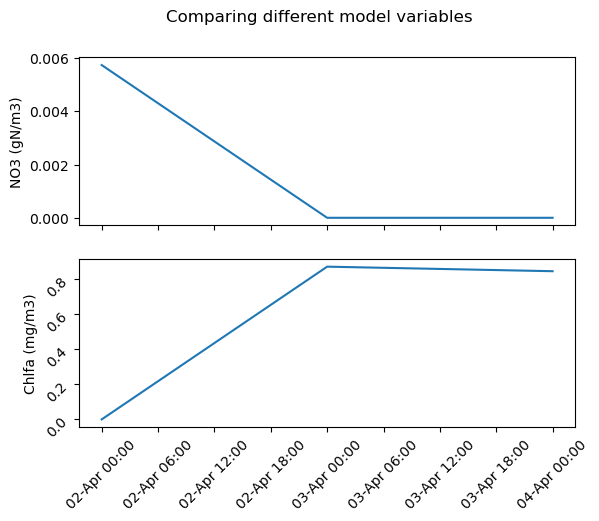

In [208]:
# Define the variables that you want to plot
variable1 = 'NO3'
variable2 = 'water_quality_output_17'

# Plot the data
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.suptitle('Comparing different model variables')
ax1.plot(data_xr[variable1].time, data_xr[variable1][:,0,-1], label=data_xr[variable1][:,0,-1].stations.values)  
ax2.plot(data_xr[variable2].time, data_xr[variable2][:,0,-1], label=data_xr[variable2][:,0,-1].stations.values)  

# Formatting the y-labels:
ax1.set_ylabel(data_xr[variable1].attrs['long_name']+' '+data_xr[variable1].attrs['units'])
ax2.set_ylabel(data_xr[variable2].attrs['long_name']+' '+data_xr[variable2].attrs['units'])
# Formatting the x-label:
ax2.tick_params(labelrotation=45)
date_form = DateFormatter("%d-%b %H:%M")
ax2.xaxis.set_major_formatter(date_form)  # if we want month written out and adding minutes

### Using .map files: 

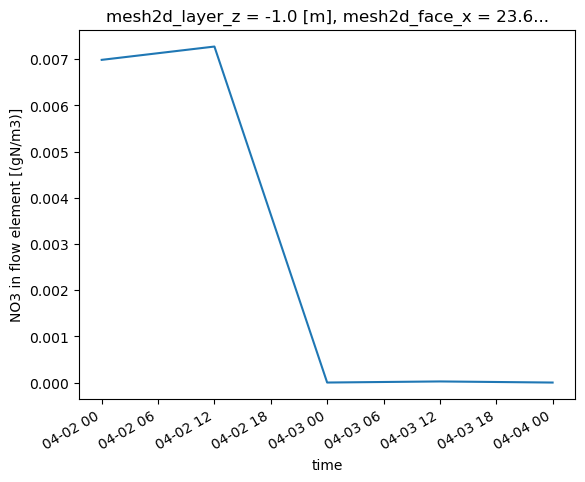

In [153]:
# Station 1 (Peiraias): -- Use this location for the map file so can compare to the .his file output above
x=23.62 
y=37.94 

## Select variable:
variable = 'mesh2d_NO3'

## Select location (vertical and horizontal):
ts = waq_xr[variable].sel(mesh2d_nLayers=-1).ugrid.sel(x=x, y=y)

## Select time:
# ts.isel(time=slice(0,3)) # Selecting the first 3 available time steps

## Plot timeseries:
ts.plot()

In [ ]:
## Could add monthly means maybe? If have more data... 

## Plot other variables of interest to https://hiseaproject.com/ (aquaculture and ports)

## Compute trends over a period:
Note: here expect no visible trend as 2 days of output

In [154]:
# Resample the data to have yearly means.
temp_year = waq_xr.sel(mesh2d_nLayers=-1).groupby('time.year').mean('time')
temp_year = temp_year.dropna(dim='mesh2d_nFaces') # drop nans if have

# collecting the NPP values
vals = temp_year['mesh2d_tem1'].values  
# Collecting the date values
years = temp_year.year.values


# Reshape to an array with as many rows as years and as many columns as there are pixels
vals2 = vals.reshape(len(years), -1)
# Do a first-degree polyfit (linear regression)
regressions = np.polyfit(years, vals2, 1)

# reshape the trends back to a 2D matrix with "lon" columns and "lat" rows
trends = regressions[0,:]#.reshape(vals.shape[1], vals.shape[2])

C:\Users\heye\Anaconda3\envs\dfm_tools_env\lib\site-packages\IPython\core\interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


C:\Users\heye\Anaconda3\envs\dfm_tools_env\lib\site-packages\cartopy\crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


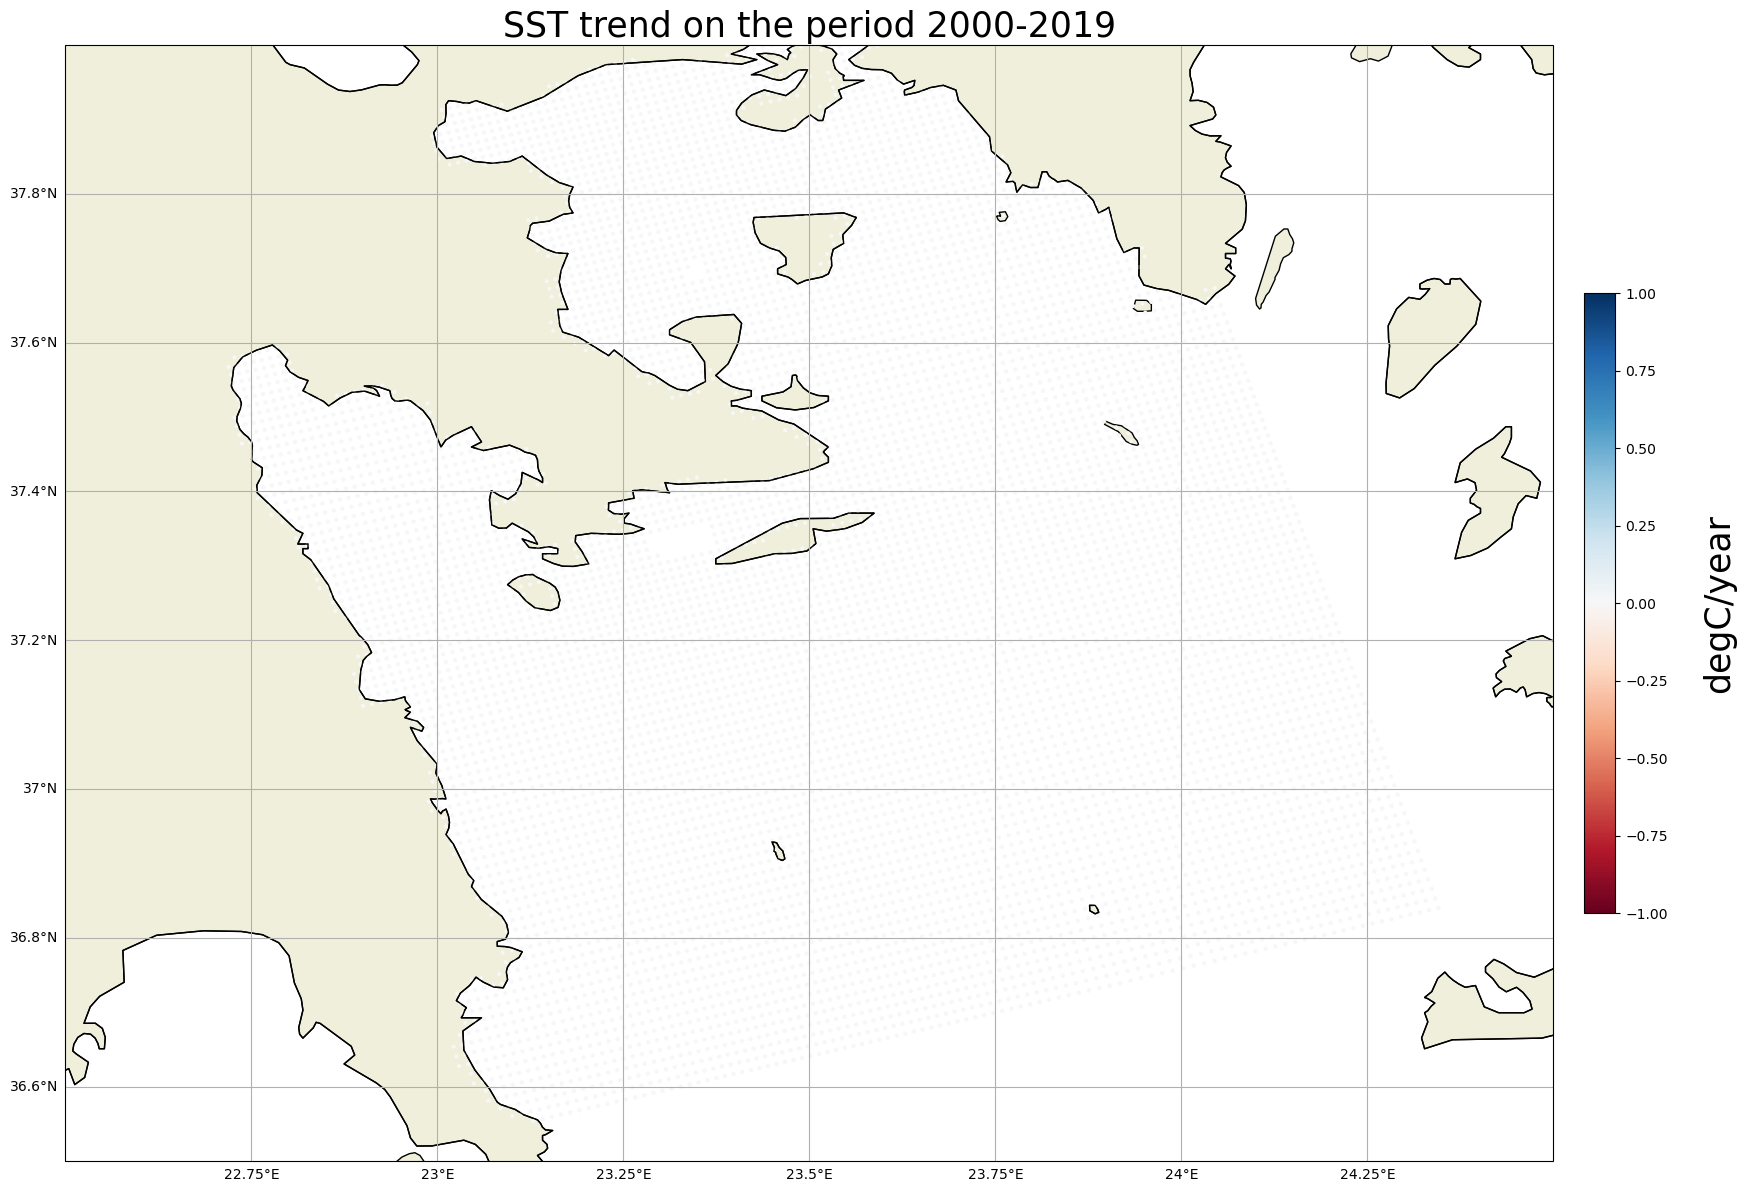

In [155]:
# Define the characteristics of the plot
f = plt.figure(figsize=(20, 16))                                # create a figure and define its size
ax = plt.axes(projection=ccrs.PlateCarree())                    # create an ax and select the projection of the map
ax.coastlines()                                                 # add the coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)     # add the longitude / latitude lines
gl.right_labels = False                                         # remove latitude labels on the right
gl.top_labels = False                                           # remove longitude labels on the top
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')          # add land mask
ax.set_extent([22.5, 24.5, 36.5, 38],crs=ccrs.PlateCarree())    # define the extent of the map [lon_min,lon_max,lat_min,lat_max]

# Plot the sea surface temperature, set the min/max values of the colorbar and the colormap to use
# im = ax.pcolor(ds['longitude'].data, ds['latitude'].data,trends,vmin=-1,vmax=1,cmap='RdBu')
im = plt.scatter(temp_year['mesh2d_nFaces'].mesh2d_face_x, temp_year['mesh2d_nFaces'].mesh2d_face_y, 
            c=trends, marker='.', linewidths=0.01, vmin=-1, vmax=1, cmap='RdBu')

# Add the titles and legend
ax.set_title('SST trend on the period 2000-2019'.format(date_plot),fontsize=25, y=1)
cbar = f.colorbar(im,ax=ax,fraction=0.02, pad=0.02)                                             # add the colorbar
cbar.set_label('degC/year', rotation=90,fontsize=25, labelpad=25)                              # add the title of the colorbar

# Save figure
# plt.savefig('out/temp_map.png')


## Note: short time period so over 1 year no trend detected! Could work on figure to not have scatter...